Starting performance test loop for 7 configurations...

--- Performance Summary Table (Graph Generation Only) ---
|   n Value | r Values Used   |   Vertices (V) |   Edges (E) |   Runtime (ms) |
|----------:|:----------------|---------------:|------------:|---------------:|
|        10 | [1]             |             10 |          10 |         0.1163 |
|        10 | [1, 2]          |             10 |          20 |         0.0486 |
|        10 | [1, 4]          |             10 |          20 |         0.0455 |
|        16 | [2]             |             16 |          16 |         0.0408 |
|        16 | [1, 2, 4]       |             16 |          48 |         0.0675 |
|        30 | [1, 3, 5]       |             30 |          90 |         0.1674 |
|        50 | [1, 2, 24]      |             50 |         150 |         0.2501 |

--- Displaying Graphical Output for last case: C_50[1, 2, 24] ---


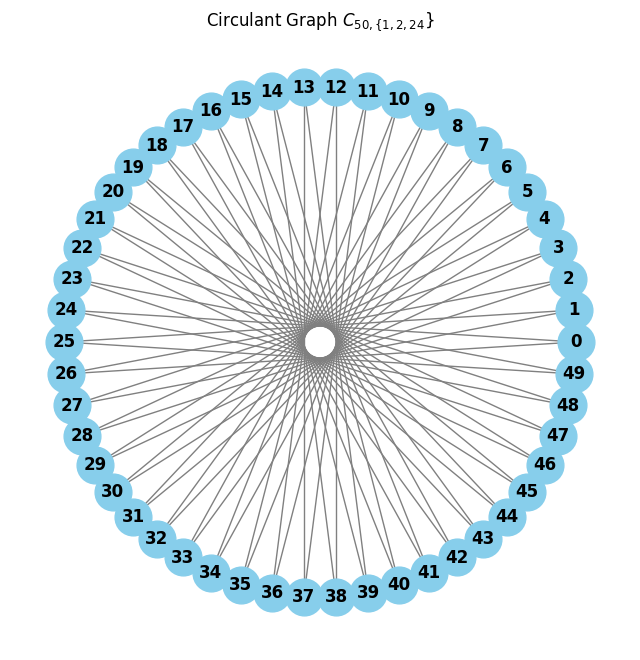

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import pandas as pd
# import itertools # Not needed for the revised test cases

def generate_circulant_graph(n, r_values):
    """
    Generates a Circulant Graph C_n(r_values) as a NetworkX graph object.

    Args:
        n (int): The number of vertices (must be > 0).
        r_values (list): A list of valid jump values (0 < r < n/2).

    Returns:
        nx.Graph: The generated circulant graph.
    """
    if isinstance(r_values, int):
        r_values = [r_values]

    # Filter for valid jump values based on n
    valid_r_values = sorted(list(set([r for r in r_values if 0 < r < n / 2])))

    if not valid_r_values:
        raise ValueError(f"No valid jump values provided for n={n} from input {r_values}.")

    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Add edges based on the circulant definition
    for i in range(n):
        for r in valid_r_values:
            neighbor1 = (i + r) % n
            G.add_edge(i, neighbor1)

    # Add metadata
    G.graph['n'] = n
    G.graph['r_values'] = valid_r_values

    return G

# The draw function is only used for visualization, not performance testing loops
def draw_circulant_graph(G):
    """
    Draws the circulant graph using a circular layout.
    """
    n = G.graph['n']
    r_values = G.graph['r_values']
    r_string = ", ".join(map(str, sorted(r_values)))
    pos = nx.circular_layout(G)

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    nx.draw_networkx_labels(G, pos, font_color='black', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    plt.title(f"Circulant Graph $C_{{{n}, \\{{{r_string}}}\\}}$")
    plt.axis('off')
    plt.show()

# --- Main execution with loop and tabulation (FIXED TEST CASES) ---

results = []

# Define different combinations of n and r values to test as (n, [r1, r2, ...]) tuples
test_cases = [
    (10, [1]),          # C_10(1) - Cycle graph
    (10, [1, 2]),       # C_10(1, 2)
    (10, [1, 4]),       # C_10(1, 4) - two jumps
    (16, [2]),          # C_16(2)
    (16, [1, 2, 4]),    # C_16(1, 2, 4) - hypercube-like
    (30, [1, 3, 5]),    # Larger graph
    (50, [1, 2, 24]),   # Even larger
]

print(f"Starting performance test loop for {len(test_cases)} configurations...")

for n_val, r_vals in test_cases:
    try:
        start_time = time.time()

        # Generate the graph
        graph = generate_circulant_graph(n_val, r_vals)

        end_time = time.time()
        runtime_ms = (end_time - start_time) * 1000 # Time in milliseconds

        num_vertices = len(graph.nodes())
        num_edges = len(graph.edges())
        used_r_vals = graph.graph['r_values'] # Get the filtered, used values

        # Store results
        results.append({
            'n Value': n_val,
            'r Values Used': str(used_r_vals),
            'Vertices (V)': num_vertices,
            'Edges (E)': num_edges,
            'Runtime (ms)': round(runtime_ms, 4)
        })

    except ValueError as e:
        print(f"Skipping test case n={n_val}, r={r_vals} due to error: {e}")

# Convert results to a pandas DataFrame for nice tabulation
try:
    df = pd.DataFrame(results)
    print("\n--- Performance Summary Table (Graph Generation Only) ---")
    print(df.to_markdown(index=False))
except ImportError:
    print("\n--- Performance Summary Table (Pandas not installed, plain text output) ---")
    print("{:<10} {:<20} {:<12} {:<10} {:<12}".format('n Value', 'r Values Used', 'Vertices (V)', 'Edges (E)', 'Runtime (ms)'))
    for row in results:
        print("{:<10} {:<20} {:<12} {:<10} {:<12.4f}".format(
            row['n Value'], row['r Values Used'], row['Vertices (V)'], row['Edges (E)'], row['Runtime (ms)']
        ))

# Optional: Display visualization for the last test case (n=50 example)
if results:
    last_row = results[-1]
    last_n = last_row['n Value']
    # We use eval here only because we stored the list as a string in the results dict
    last_r = eval(last_row['r Values Used'])
    print(f"\n--- Displaying Graphical Output for last case: C_{last_n}{last_r} ---")
    final_graph_for_display = generate_circulant_graph(last_n, last_r)
    draw_circulant_graph(final_graph_for_display)
